In [1]:
# import libraries
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from scipy.stats import randint
from sklearn.impute import SimpleImputer, KNNImputer
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm

In [2]:
from lussi.stackoverflow import *
from lussi.ziprecruiter import *

"""
Run like this: 
(.venv) hurricane:krijudato afraser$ python ./src/lussi/run.py
"""

# run this to build out your caches.
nogit_data_dir = "622data_nogit"
#build_stack(data_dir=nogit_data_dir)
#build_zip(data_dir=nogit_data_dir)

# this is how you load.
raw_stack  = load_stack(data_dir = nogit_data_dir, stack_type=StackType.RAW)
wide_stack = load_stack(data_dir = nogit_data_dir, stack_type=StackType.WIDE)
ziprecruiter = load_zip(data_dir = nogit_data_dir)

#print(raw_stack.head())
#print(wide_stack.head())
#print(ziprecruiter.head())

In [3]:
def group_gender(gender):
    gender = str(gender).lower()  # converts to lowercase 
    if 'female' in gender or 'woman' in gender:
        return 'Female'
    elif 'male' in gender or 'man' in gender:
        return 'Male'
    else:
        return 'Other'

filtered_stack = (
    wide_stack
    .query("Year != 2019 and Year != 2020")  # No salary
    .query("Year != 2017")  # No age
    .query("Country == 'United States'")  # Forget that!
    .assign(gender_grouped=wide_stack['Gender'].apply(group_gender))  # Add gender_grouped, simplify to m/f/o
    .drop('Gender', axis=1) 
    .drop('Sexuality', axis=1)  # DE: sexuality_grouped as either straight or lgbtq+
    .drop('Ethnicity', axis=1)  # DE: ethnicity_grouped, either minority or non-minority
    .drop('PlatformWorkedWith', axis=1)  #DE: expanded in calculated columns
    .drop('LanguageWorkedWith', axis=1)  #DE: expanded in calculated columns
    .drop('DatabaseWorkedWith', axis=1)  #DE: expanded in calculated columns
    .drop('US_State', axis=1) # too few 
    .drop('Country', axis=1) 
    .drop('YearsCodePro', axis=1) # DE: We built YearsCodeProAvg integer column to replace this.
    .drop('OrgSize', axis=1) # DE: We built YearsCodeProAvg in DE
    .drop('Age', axis=1) # DE: we built average age for this.
    .drop('DevType', axis=1) # too self reported to be much use.
    .query('AnnualSalary > 1')   
)

In [4]:
# encoding / preprocessing
us_data = filtered_stack

# columns to keep (all features)
cols_to_keep = ['AnnualSalary','YearsCodeProAvg', 'OrgSizeAvg', 
                'scala', 'python', 'javascript', 'EdLevel',
                'postgresql', 'ethnicity_grouped', 'AgeAvg', 
               'gender_grouped','aws','mysql','redis','sql',
               'java','ruby','php','c','mongodb',
               'oracle','ibmdb2','sqlite','kubernetes',
               'linux','windows']

# new dataframe with specific columns
df_new = us_data[cols_to_keep].copy()

In [12]:
import pandas as pd

# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df_new['AnnualSalary'].quantile(0.25)
Q3 = df_new['AnnualSalary'].quantile(0.75)

# Calculate the IQR
IQR = Q3 - Q1

# Define outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers from the dataframe
df_filtered = df_new[(df_new['AnnualSalary'] >= lower_bound) & (df_new['AnnualSalary'] <= upper_bound)]

# One-hot encode categorical variables
df_encoded = pd.get_dummies(df_filtered, drop_first=True)

# Identify all boolean columns
bool_cols = df_encoded.select_dtypes(include=['bool']).columns

# Convert boolean columns to integers (True -> 1, False -> 0)
df_encoded[bool_cols] = df_encoded[bool_cols].astype(int)

# Update X and Y with the filtered data
X = df_encoded.drop(columns=['AnnualSalary'])
Y = df_encoded['AnnualSalary']


In [13]:
# Split the dataset into 80% training and 20% testing data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# impute target variable train set
#Y_train_imputed = Y_train.copy().values.reshape(-1, 1)  
#Y_train_imputed = knn_imputer.fit_transform(Y_train_imputed)

In [7]:
#from sklearn.feature_selection import RFE

#model = xgb.XGBRegressor()
#rfe = RFE(model, n_features_to_select=10)  # Select top 10 features
#fit = rfe.fit(X_train, Y_train_imputed)
#print(fit.support_)  # Boolean mask of selected features

# Get the names of the features
#feature_names = X_train.columns

# Create a DataFrame to show selected features
#selected_features = feature_names[selected_features_mask]
#print(selected_features)

# selects which features to keep in the model

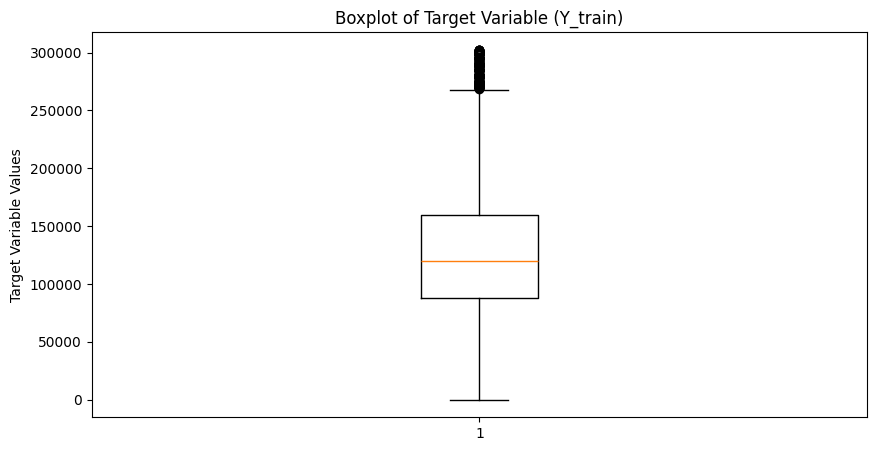

In [14]:
plt.figure(figsize=(10, 5))
plt.boxplot(Y_train)
plt.title('Boxplot of Target Variable (Y_train)')
plt.ylabel('Target Variable Values')
plt.show()

<Axes: >

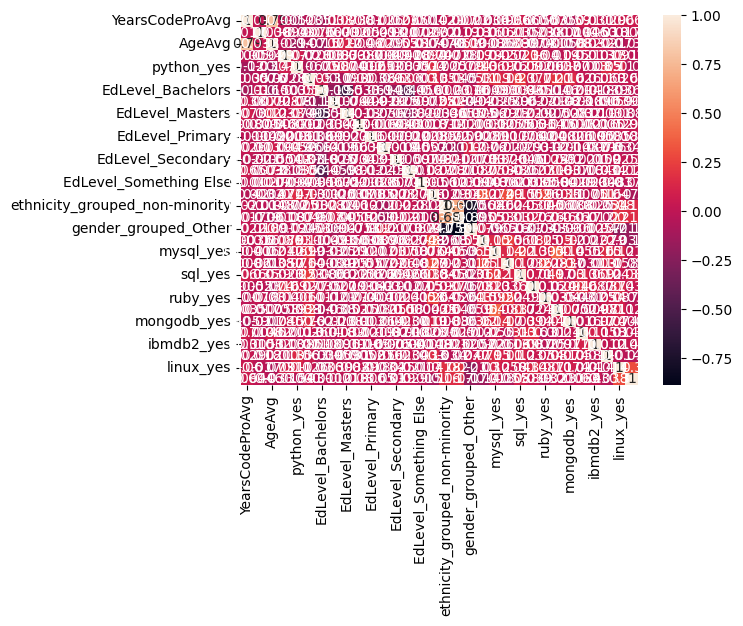

In [15]:
corr_matrix = df_encoded.drop(columns=['AnnualSalary']).corr()
sns.heatmap(corr_matrix, annot=True)

In [16]:
# Define the parameter grid
param_grid = {
    'n_estimators': randint(200, 1000), # initial was randint(100, 500) ; updated was randint(200, 1000)
     'max_depth': randint(2,6), # initial was (3,10); updated to  (2,6)
     'learning_rate': [0.01, 0.05, 0.1], # initial was [0.001, 0.01, 0.1, 0.3]; updated to [0.01, 0.05, 0.1]
     'subsample': [0.6, 0.8, 1.0],
     'colsample_bytree': [0.6, 0.8, 1.0],
     'gamma': [0, 0.1, 0.3, 0.5],
     'min_child_weight': [10, 15, 20] # inital was [1,5,10]; updated to [10, 15, 20]
}

# Instantiate the model and RandomizedSearchCV
xgb_r = xgb.XGBRegressor(objective='reg:squarederror', seed=123)
random_search = RandomizedSearchCV(estimator=xgb_r, 
                                   param_distributions=param_grid, 
                                   n_iter=50, 
                                   scoring='neg_mean_squared_error', 
                                   cv=5, 
                                   verbose=1, 
                                   random_state=42)

# Fit the random search model
random_search.fit(X_train, Y_train)
print(f"Best parameters: {random_search.best_params_}")

# Predict using the best model
best_model = random_search.best_estimator_
pred = best_model.predict(X_test)

# calculate RMSE
rmse = np.sqrt(mean_squared_error(Y_test, pred))
print(f"RMSE: {rmse}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters: {'colsample_bytree': 0.6, 'gamma': 0.5, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 15, 'n_estimators': 976, 'subsample': 0.8}
RMSE: 45398.982178996324


In [ ]:
# Plot feature importance
xgb.plot_importance(best_model, importance_type='weight', max_num_features=20)
plt.title('Top Feature Importance')
plt.show()

In [11]:
# Compute the R² score
r2 = r2_score(Y_test, pred)
print("R²: %f" % r2)

R²: 0.007583


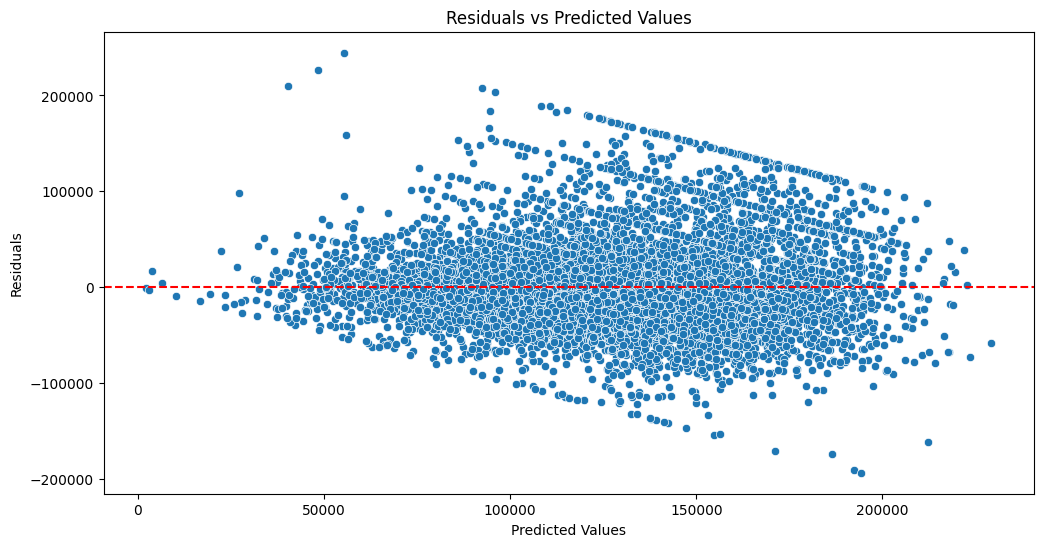

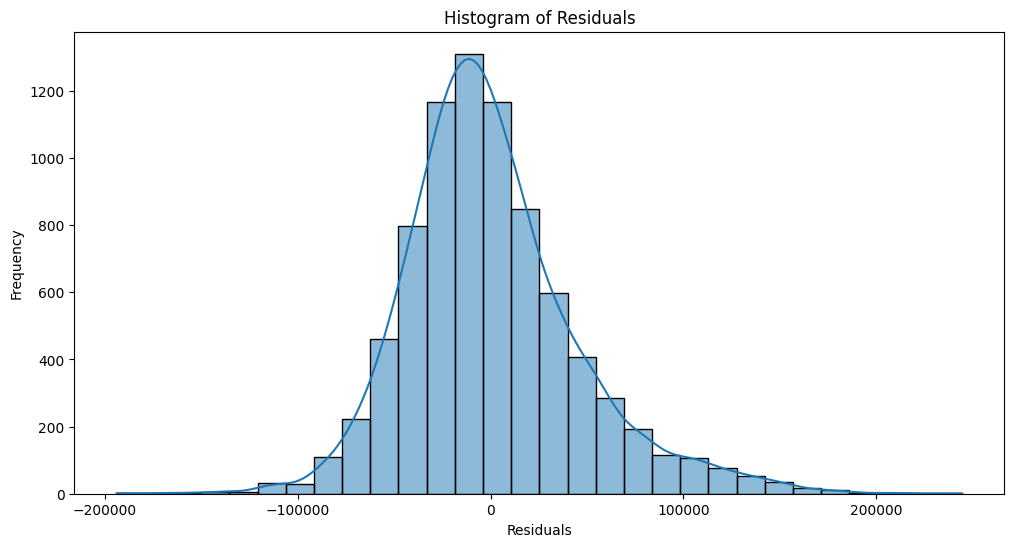

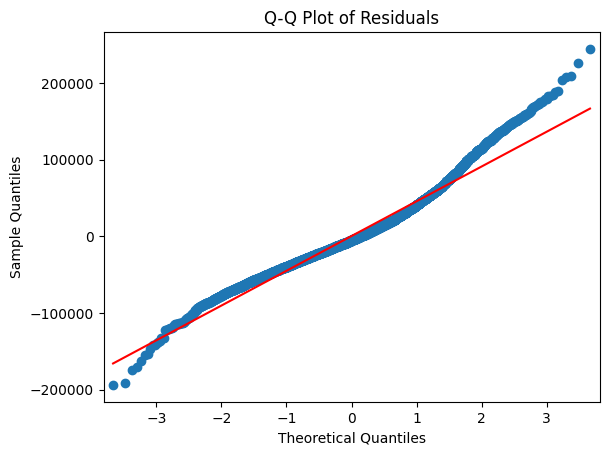

In [17]:

residuals = Y_test - pred  # Calculate residuals

# create data frame for plotting
residuals_df = pd.DataFrame({
    'Actual': Y_test,
    'Predicted': pred,
    'Residuals': residuals
})

# Plot Residuals vs Predicted Values
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Predicted', y='Residuals', data=residuals_df)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

# Histogram of Residuals
plt.figure(figsize=(12, 6))
sns.histplot(residuals, bins=30, kde=True)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Q-Q Plot
sm.qqplot(residuals, line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()

In [ ]:
# Predictions on the training set
train_pred = best_model.predict(X_train)

# Predictions on the testing set
test_pred = best_model.predict(X_test)

# RMSE on the training set
train_rmse = np.sqrt(mean_squared_error(Y_train, train_pred))
print(f"Training RMSE: {train_rmse}")

# RMSE on the testing set
test_rmse = np.sqrt(mean_squared_error(Y_test, test_pred))
print(f"Testing RMSE: {test_rmse}")

# R² on the training set
train_r2 = r2_score(Y_train, train_pred)
print(f"Training R²: {train_r2}")

# R² on the testing set
test_r2 = r2_score(Y_test, test_pred)
print(f"Testing R²: {test_r2}")

# this suggests that the model is not overfitting and it's performing similarly on the test & train set


In [ ]:
# One-hot encode categorical variables
#df_encoded_outlier = pd.get_dummies(df_new, drop_first=True)

# Identify all boolean columns
#bool_cols_outlier = df_encoded.select_dtypes(include=['bool']).columns

# Convert boolean columns to integers (True -> 1, False -> 0)
#df_encoded_outlier[bool_cols] = df_encoded_outlier[bool_cols].astype(int)

# Update X and Y with the filtered data
#X_out = df_encoded_outlier.drop(columns=['AnnualSalary'])
#Y_out = df_encoded_outlier['AnnualSalary']

# Split the dataset into 80% training and 20% testing data
#X_train_out, X_test_out, Y_train_out, Y_test_out = train_test_split(X_out, Y_out, test_size=0.2, random_state=42)

# Define the parameter grid
#param_grid = {
#    'n_estimators': randint(200, 1000), # initial was randint(100, 500) ; updated was randint(200, 1000)
#     'max_depth': randint(2,6), # initial was (3,10); updated to  (2,6)
#     'learning_rate': [0.01, 0.05, 0.1], # initial was [0.001, 0.01, 0.1, 0.3]; updated to [0.01, 0.05, 0.1]
#     'subsample': [0.6, 0.8, 1.0],
#     'colsample_bytree': [0.6, 0.8, 1.0],
#     'gamma': [0, 0.1, 0.3, 0.5],
#     'min_child_weight': [10, 15, 20] # inital was [1,5,10]; updated to [10, 15, 20]
#}

# Instantiate the model and RandomizedSearchCV
#xgb_r_out = xgb.XGBRegressor(objective='reg:squarederror', seed=123)
#random_search_out = RandomizedSearchCV(estimator=xgb_r_out, 
#                                   param_distributions=param_grid, 
#                                   n_iter=50, 
#                                   scoring='neg_mean_squared_error', 
#                                   cv=5, 
#                                   verbose=1, 
#                                   random_state=42)

# Fit the random search model
#random_search_out.fit(X_train_out, Y_train_out)
#print(f"Best parameters: {random_search_out.best_params_}")



In [ ]:
# Predict using the best model
best_model_out = random_search_out.best_estimator_
pred_out = best_model_out.predict(X_test_out)

# calculate RMSE
rmse_out = np.sqrt(mean_squared_error(Y_test_out, pred_out))
print(f"RMSE: {rmse}")

# Compute the R² score
r2_out = r2_score(Y_test_out, pred_out)
print("R²: %f" % r2)